In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [2]:
def pmw(workload, x, eps=0.01, beta=0.1, k=0, show_messages=True, to_return='pd', ):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    sigma = 10 * math.log(1 / delta, np.e) * ((math.log(m, np.e)) ** (1 / 4)) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    y_list = [y_t]
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    algo_answers = []
    update_times = []
    d_t_hat_list = []
    # iterate through time = (0, k)
    for time, query in enumerate(workload):

        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=sigma, size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        d_t_hat_list.append(d_t_hat)
        #print("Current noisy distance:")
        #print(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold:
            #print("Lazy")
            algo_answers.append(np.dot(query, x_list[time]))
            x_list.append(x_list[time])
            update_list.append('no')
            continue

        # update round: update histogram and return noisy answer
        else:
            #print("update")
            update_list.append('yes')
            update_times.append(time)

            # step a
            if d_t_hat > 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            y_list.append(y_t)

            # step b
            x_t = y_t / np.sum(y_t)
            x_list.append(x_t)
        
        update_count = update_list.count('yes')

        if update_count > n * math.log(m, np.e) ** (1 / 2):
            return "failure"
        else:
            algo_answers.append(a_t_hat / np.sum(x))

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(algo_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))

    def print_outputs():
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    
    if show_messages:
        print_outputs()
        plot_error()
        
    if to_return == "update_count":
        return update_count
    
    if to_return == "pd":
        d = {
            'queries': workload.tolist(), 
            'd_t_hat': d_t_hat_list, 
            'updated': update_list,
            'algo_ans': algo_answers,
            'real_ans': real_ans.tolist(),
            'abs_error': abs_error,               
            'rel_error': rel_error,
             }
        test_data = pd.DataFrame(data=d)
        return test_data

In [3]:
x_peaks = np.array([1000, 8000, 1300, 1250, 9000, 1450, 1700, 1720])
W_allrange = workload.AllRange(8).dense_matrix()

In [4]:
m = x_peaks.size  # database len
n = x_peaks.sum()
n * math.log(m, 10) ** (1 / 2)

24156.89211530533

Here are some preliminary results: 

The following are results for updating the privacy budget by scales of 10. 1000 experiments were run at each privacy budget. The query used was an allrange workload with 36 total queries. The database comprised of 25420 total individuals: [1000, 8000, 1300, 1250, 9000, 1450, 1700, 1720]. 

As epsilon increases, so does the amount of times the algorithm updates. 

In [5]:
average_update_count_list = []
epsilons_to_try = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 750, 1000, 10000, 100000]

def update_count_for_eps(set_eps):
    total_update_count = 0
    num_exp = 1000
    for i in range(num_exp):
        total_update_count += pmw(workload=W_allrange,
                                  x=x_peaks,
                                  eps=set_eps,
                                  show_messages=False,
                                  to_return='update_count')
    
    average_update_count = total_update_count / num_exp
    print(f'average update_count for privacy budget of {set_eps} is \t {average_update_count}')
    return average_update_count
    
for i in epsilons_to_try:
    average_update_count_list.append(update_count_for_eps(set_eps=i))

print(average_update_count_list)

average update_count for privacy budget of 0.0001 is 	 0.0
average update_count for privacy budget of 0.001 is 	 0.0
average update_count for privacy budget of 0.01 is 	 18.549
average update_count for privacy budget of 0.1 is 	 35.0
average update_count for privacy budget of 1 is 	 35.0
average update_count for privacy budget of 10 is 	 35.0
average update_count for privacy budget of 100 is 	 35.0
average update_count for privacy budget of 250 is 	 35.0
average update_count for privacy budget of 500 is 	 35.0
average update_count for privacy budget of 750 is 	 35.0
average update_count for privacy budget of 1000 is 	 35.0
average update_count for privacy budget of 10000 is 	 35.0
average update_count for privacy budget of 100000 is 	 35.0
[0.0, 0.0, 18.549, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0]


In [6]:
average_update_count_list = []
betas_to_try = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def update_count_for_beta(set_beta, set_eps):
    total_update_count = 0
    num_exp = 1000
    for i in range(1000):
        total_update_count += pmw(workload=W_allrange,
                                  x=x_peaks,
                                  eps=set_eps,
                                  beta=set_beta,
                                  show_messages=False,
                                  to_return='update_count')
    
    average_update_count = total_update_count / num_exp
    print(f'average update_count for beta value of {set_beta} is \t {average_update_count}')
    return average_update_count
    
for i in betas_to_try:
    average_update_count_list.append(update_count_for_beta(set_beta=i, set_eps=0.01))

print(average_update_count_list)

average update_count for beta value of 0.001 is 	 7.552
average update_count for beta value of 0.01 is 	 11.963
average update_count for beta value of 0.1 is 	 18.531
average update_count for beta value of 0.2 is 	 21.325
average update_count for beta value of 0.3 is 	 22.719
average update_count for beta value of 0.4 is 	 23.848
average update_count for beta value of 0.5 is 	 24.812
average update_count for beta value of 0.6 is 	 25.649
average update_count for beta value of 0.7 is 	 26.247
average update_count for beta value of 0.8 is 	 26.624
average update_count for beta value of 0.9 is 	 26.852
average update_count for beta value of 1 is 	 27.006
[7.552, 11.963, 18.531, 21.325, 22.719, 23.848, 24.812, 25.649, 26.247, 26.624, 26.852, 27.006]


In [7]:
average_update_count_list = []
k_to_try = [1, 5, 10, 15, 20, 25, 30, 36, 100]

def update_count_for_k(set_beta, set_eps, set_k):
    total_update_count = 0
    num_exp = 1000
    for i in range(1000):
        total_update_count += pmw(workload=W_allrange,
                                  x=x_peaks,
                                  eps=set_eps,
                                  beta=set_beta,
                                  k=set_k,
                                  show_messages=False,
                                  to_return='update_count')
    
    average_update_count = total_update_count / num_exp
    print(f'average update_count for k value of {set_k} is \t {average_update_count}')
    return average_update_count
    
for i in k_to_try:
    average_update_count_list.append(update_count_for_k(set_beta=0.1, set_eps=0.01, set_k=i))

print(average_update_count_list)

average update_count for k value of 1 is 	 31.641
average update_count for k value of 5 is 	 26.337
average update_count for k value of 10 is 	 23.401
average update_count for k value of 15 is 	 21.959
average update_count for k value of 20 is 	 21.044
average update_count for k value of 25 is 	 20.423
average update_count for k value of 30 is 	 19.632
average update_count for k value of 36 is 	 18.548
average update_count for k value of 100 is 	 16.181
[31.641, 26.337, 23.401, 21.959, 21.044, 20.423, 19.632, 18.548, 16.181]


## General TODO:
Say we have a dataset [1,2,3,4,5,6,7]
Alice some random set of queries that only query indexes 1-4. Alice's queries come first and use all the budget. Practically that means alice runs queries unitl output = failure. Then Bob does queries on index 5-7 on the synthetic database. 

In [8]:
x_small = np.array([10, 80, 13, 12, 90, 14, 17, 17])
m = x_small.size  # database len
n = x_small.sum()
print(f'the threshold for failure is {n * math.log(m, 10) ** (1 / 2)}')

the threshold for failure is 240.4285485905684


- Compare PMW with both Alice/Bob, and with just Alice and just bob. Calculate error difference. 
		○ Use a smaller database so the threshold is less
		○ Create a parallel list of people
		○ Split k and epsilon in half

In [9]:
alice = np.array([1, 1, 1, 1, 0, 0, 0, 0])
alice

array([1, 1, 1, 1, 0, 0, 0, 0])

In [10]:
alice_firstfour = np.random.randint(2, size=(250,4))
alice_lastfour = np.zeros((250,4))
alice = np.hstack((alice_firstfour, alice_lastfour))
bob = np.hstack((alice_lastfour, alice_firstfour))

for total setting: set_beta=0.1, set_eps=0.01, k = 500

for separate setting: set_beta=0.1, set_eps=0.005, k = 250

Original database: [10 80 13 12 90 14 17 17]

Normalized database: [0.03952569 0.31620553 0.0513834  0.04743083 0.35573123 0.05533597
 0.06719368 0.06719368]

Updated Database = [0.14433535 0.07889895 0.09895422 0.09175857 0.06290834 0.1150826
 0.18102384 0.22703814]

Update Count = 32

threshold=9.586305335647857



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-21.103214,yes,0.041588,0.039526,0.002062,0.052179
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",24.524038,yes,0.354213,0.355731,0.001518,0.004267
2,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9.482678,no,0.369267,0.407115,0.037848,0.092966
3,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-10.461104,yes,0.454065,0.454545,0.000480,0.001056
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]",44.127315,yes,0.810129,0.810277,0.000148,0.000182
5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]",30.484409,yes,0.865863,0.865613,0.000250,0.000289
6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",16.337878,yes,0.929966,0.932806,0.002840,0.003045
7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.478840,no,1.000000,1.000000,0.000000,0.000000
8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",50.235431,yes,0.313095,0.316206,0.003110,0.009836
9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",34.806106,yes,0.369229,0.367589,0.001640,0.004461


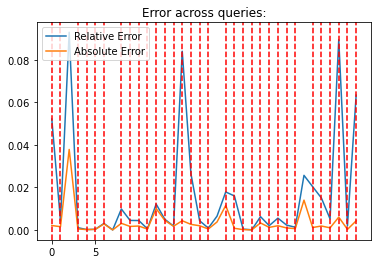

In [11]:
pmw(workload=W_allrange, x=x_small, eps=10, beta=0.1, k=8, to_return='pd')
